# Introduction

This notebook generates the different synthetic traces.

In [1]:
import os
import logging
from datetime import datetime
import pandas as pd
import numpy as np
from collections import namedtuple
from functools import partial

#%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use("bmh")

import matplotlib
matplotlib.rcParams["figure.figsize"] = (15, 5)

%matplotlib inline

from malloovia_syntraces import (
    pink_noise,
    brown_noise,
    white_noise,
    Period)

BASE_DIR = '.'
OUTPUT_DIR = F'{BASE_DIR}/traces'

def distribute_uniform(N):
    '''Takes a number of request per hour and distributes them with
    a random uniform distribution in seconds. Returns a numpy array'''   
    requests = np.random.randint(0, Period.hour.in_seconds(), size=N)
    unique, counts = np.unique(requests, return_counts=True)
    result = np.zeros(Period.hour.in_seconds(), dtype=np.int64)
    result[unique] = counts
    return result

def generate_uniform_period(rph, seed=None):
    '''Generates trace in seconds from a trace in hours using a random
    uniform distribution.
    
    The input is a numpy array whose elements are the requests per hour
    for several hours.
    
    It returns a numpy array whose elements are the requests per second.
    '''
    np.random.seed(seed)

    in_seconds = []
    previous_hour = rph[0]
    for hour in rph:
        requests = distribute_uniform(hour)
        in_seconds.extend(requests)
        previous_hour = hour
    return np.array(in_seconds)

def distribute_in_seconds(N, distrib):
    """Distributes N requests in 3600 instants, following the distribution
    (probability weights) given.
  
    Returns a list with 3600 elements. Each of them is the number of
    requests for the corresponding second."""
  
    requests = np.random.choice(np.arange(0, 3600), size=N, p=distrib, replace=True)

    # Antes usaba Counter para contar repeticiones en el mismo timestamp
    # He descubierto que np.unique es el doble de rápido
    result = np.zeros(3600, dtype=np.int64)
    unique, counts = np.unique(requests, return_counts=True)
    result[unique] = counts
    return result

def distribute_smooth(rph, prev_rph, next_rph):
    """Distributes with a smooth distribution the requests per hour
    between its seconds
    
    For each hour, it generates a distribution with the requests per
    second (rps). It has a peak in the middle. The rps goes up until
    the peak if the previous hour had more rph than the next hour,
    and down otherwise. The rph will be randomly distributed following
    this distribution.
    
    Args:
    
        rph: numpy array with the workload as requests per hour
        prev_rph: rph of the hour before the first hour in rph
        next_prh: rph of the hour after the last hour in rph

    
    Returns an array with the rps
    """
    in_seconds = []
    for i, hour in enumerate(rph):
        if i == len(rph) - 1:
            next_hour = next_rph
        else:
            next_hour = rph[i+1]        
        h = 1/4*(6*hour - prev_rph - next_hour)
        ramp = np.linspace((prev_rph+hour)/2, h, num=3600//2)
        ramp = np.append(ramp, np.linspace(h, (hour+next_hour)/2, num=3600//2))  
        ramp = ramp.clip(min=0)
        ramp /= np.sum(ramp)
        requests = distribute_in_seconds(hour, ramp)
        in_seconds.extend(requests)
        prev_rph = hour
    return np.array(in_seconds)

def constant_distributed_workload(original_workload, original_period, destination_period):
    '''Returns an integer array that represents the distribution of a workload
    accumulated periodically in a smaller period. Tries to distribute equally
    the workload between the smaller periods
    
    Parameters:
    - original_workload: int array representing the accumulated requests in the
        original period, e.g., the accumulated requests per hour
    
    - original_period: duration in seconds of the original period, e.g., 3600 for
        a period of one hour
        
    - destination_period: duration in seconds of the destination period, e.g., 1 for
        a period of one second
    '''
    if original_period <= destination_period:
        raise ValueError('original_period should be greater than destination_period')
        
    if original_period % destination_period != 0:
        raise ValueError('The destination period has to be a divisor of the original period')
    
    n_intra_samples = int(original_period // destination_period)
    
    new_len = n_intra_samples * len(original_workload)
    new_workload = new_len * [0] # placeholder 
    
    for original_index, accumulated_sample in enumerate(original_workload):
        new_index = original_index * n_intra_samples
        int_average = accumulated_sample // int(n_intra_samples)
        
        for i in range(n_intra_samples):
            new_workload[new_index + i] = int_average
        
        remainder = accumulated_sample % n_intra_samples
        if remainder > 0:
            separation = n_intra_samples // remainder
            for i in range(remainder):
                new_workload[new_index + (i * separation)] += 1
    
    assert(sum(original_workload) == sum(new_workload))
    
    return new_workload

def process_noise_and_combine_with_base_trace(noise_per_sec, base_trace_per_sec,
                                              name):
    '''Receives two arrays, one with the noise per second and the other with
    the base trace per second. The last parameter is the name of new trace.
    
    Generates a list with the noise processed (normalized and scaled) combined
    with the base trace.'''
    # Normalize the noise
    abs_max = abs(max(noise_per_sec, key=abs))
    noise_normalized_per_sec = [i/abs_max for i in noise_per_sec]

    # Scale the noise
    scaled_noise = np.array(base_trace_per_sec) * noise_normalized_per_sec
    
    # Combine base trace and noise
    with_noise = np.add(base_trace_per_sec, scaled_noise)
    
    # Convert to int
    with_noise_int = np.round(with_noise).astype('int')
    
    # Eliminate values smaller than 0
    with_noise_int = with_noise_int.clip(min=0)
    
    return with_noise_int
    
def systhetize_trace_with_noise(noise_generating_func, base_secs, name):
    '''Receives a function to generate noise and generates noise per sec
    for each hour in the year. The value is returned as a list'''
    noise_per_sec = []
    for i in range(int(Period.year.in_hours())):
        noise_per_sec.extend(noise_generating_func(Period.hour.in_seconds(), seed=i))
    
    return process_noise_and_combine_with_base_trace(
        noise_per_sec, base_secs, name)
    
def synthetize_traces_from_sec_trace(base_filename_year_in_secs):
    '''Receives the path for a file with the trace in requests per secsfor all the
    year and returns a DataFrame of traces with these synthetic traces: constant,
    uniform, brown noise, white noise and pink noise'''
    
    df_real_secs = pd.read_csv(base_filename_year_in_secs, index_col=0, parse_dates=True)

    # Get the origin date for having the correct date in the index
    dateOrigin = df_real_secs.index[0]

    df_hours = df_real_secs.resample('H', label='right').sum().copy()
    
    return synthetize_traces_from_hour_trace_df(df_hours, dateOrigin)

def synthetize_traces_from_hour_trace(base_filename_year_in_secs):
    '''Receives the path for a file with the trace in requests per hour
    for all the year and returns a DataFrame of traces with these synthetic
    traces: constant, uniform, brown noise, white noise and pink noise'''
    
    df_hours = pd.read_csv(base_filename_year_in_secs, index_col=0, parse_dates=True)

    return synthetize_traces_from_hour_trace_df(df_hours, df_hours.index[0])

def synthetize_traces_from_hour_trace_df(df_hours, dateOrigin):
    '''Receives a DataFrame with the trace in requests per hour for all the year
    and returns a DataFrame of traces with these synthetic traces: constant,
    uniform, brown noise, white noise and pink noise'''
    result = {}
    
    workload_in_hours = df_hours.iloc[:,0].values.tolist()
    
    # Create a list of ints for each second distributing between seconds the workload in hours
    base_secs = constant_distributed_workload(
        original_workload=workload_in_hours,
        original_period = Period.hour.in_seconds(),
        destination_period = 1) # 1 second

    result['constant'] = base_secs
    
    result['brown'] = systhetize_trace_with_noise(brown_noise, base_secs, 'brown')
    result['white'] = systhetize_trace_with_noise(white_noise, base_secs, 'white')
    result['pink'] = systhetize_trace_with_noise(pink_noise, base_secs, 'pink')

    result['uniform'] = generate_uniform_period(workload_in_hours, seed=70)
    result['smooth'] = distribute_smooth(workload_in_hours,
                                         workload_in_hours[0], workload_in_hours[-1])

    result_df = pd.DataFrame(result)
    result_df.set_index(pd.to_datetime(result_df.index, unit='s', origin=dateOrigin),
                        inplace=True)
       
    return result_df

# World Cup

In [2]:
df_wc_traces = synthetize_traces_from_sec_trace(f'{BASE_DIR}/traces/wc98_real.csv.gz')

In [3]:
for t in df_wc_traces:
    filename = f'{OUTPUT_DIR}/wc98_{t}.csv.gz'
    print(f'Saving {filename}')
    df_wc_traces[t].to_frame().to_csv(filename, compression='gzip')

Saving ./traces/wc98_brown.csv.gz
Saving ./traces/wc98_constant.csv.gz
Saving ./traces/wc98_pink.csv.gz
Saving ./traces/wc98_smooth.csv.gz
Saving ./traces/wc98_uniform.csv.gz
Saving ./traces/wc98_white.csv.gz


In [4]:
df_wc_traces.describe()

,brown,constant,pink,smooth,uniform,white
count,3.153600e+07,3.153600e+07,3.153600e+07,3.153600e+07,3.153600e+07,3.153600e+07
mean,1.738063e+02,1.732648e+02,1.734498e+02,1.732648e+02,1.732648e+02,1.732785e+02
std,3.231565e+02,3.084864e+02,3.169479e+02,3.119447e+02,3.087666e+02,3.145615e+02
min,0.000000e+00,2.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
25%,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01,2.400000e+01
50%,5.800000e+01,5.900000e+01,5.800000e+01,5.900000e+01,5.900000e+01,5.800000e+01
75%,2.050000e+02,2.220000e+02,2.090000e+02,2.180000e+02,2.190000e+02,2.110000e+02
max,4.858000e+03,3.087000e+03,5.092000e+03,3.949000e+03,3.306000e+03,5.063000e+03


# Wikipedia

In [5]:
df_wiki_traces = synthetize_traces_from_hour_trace(f'traces/wikipedia_2014_hours.csv.gz')

In [6]:
for t in df_wiki_traces:
    filename = f'{OUTPUT_DIR}/wiki_{t}.csv.gz'
    print(f'Saving {filename}')
    df_wiki_traces[t].to_frame().to_csv(filename, compression='gzip')

Saving ./traces/wiki_brown.csv.gz
Saving ./traces/wiki_constant.csv.gz
Saving ./traces/wiki_pink.csv.gz
Saving ./traces/wiki_smooth.csv.gz
Saving ./traces/wiki_uniform.csv.gz
Saving ./traces/wiki_white.csv.gz


In [7]:
df_wiki_traces.head()

,brown,constant,pink,smooth,uniform,white
2014-01-01 00:00:00,3254,2226,2569,2295,2269,2905
2014-01-01 00:00:01,3292,2225,2846,2350,2208,2379
2014-01-01 00:00:02,3314,2225,2872,2199,2215,2601
2014-01-01 00:00:03,3360,2226,3239,2208,2221,3088
2014-01-01 00:00:04,3364,2225,3261,2207,2236,2943


# Paper figures

In [8]:
COLOR_REAL = 'green'
COLOR_SMOOTH = '#348ABD'
COLOR_UNIFORM = 'orange'
COLOR_BROWN = '#c47033'
COLOR_CONSTANT = 'black'
COLOR_WHITE = 'grey'
COLOR_PINK = '#ff758d'

COLORS_DICT = {
    'real': COLOR_REAL,
    'smooth': COLOR_SMOOTH,
    'uniform': COLOR_UNIFORM,
    'constant': COLOR_CONSTANT,
    'white': COLOR_WHITE,
    'pink': COLOR_PINK,
    'brown': COLOR_BROWN}
COLORS = [COLOR_SMOOTH, COLOR_UNIFORM, COLOR_CONSTANT, COLOR_WHITE, COLOR_PINK, COLOR_BROWN]

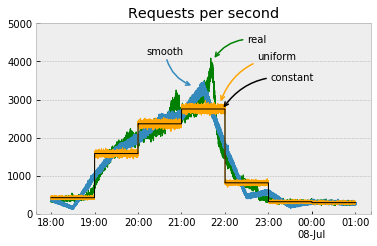

In [9]:
def arrowprops(color):
    return dict(arrowstyle='->',
                color=color,
                lw=1.5,
                connectionstyle='arc3,rad=0.3',
                )

fig, ax = plt.subplots()
start = 66*Period.day.in_seconds() + 18*Period.hour.in_seconds()
end = start + 7*Period.hour.in_seconds()
zoom = slice(start, end)

df_real_secs = pd.read_csv(f'{BASE_DIR}/traces/wc98_real.csv.gz', index_col=0, parse_dates=True)

df_real_secs['requests'][zoom].plot(ax=ax, linewidth=1, color=COLOR_REAL)
df_wc_traces['smooth'][zoom].plot(ax=ax, linewidth=2, color=COLOR_SMOOTH)
df_wc_traces['uniform'][zoom].plot(ax=ax, linewidth=1,color=COLOR_UNIFORM)
df_wc_traces['constant'][zoom].plot(ax=ax, linewidth=1, 
                                       figsize=(6, 3.5), title='Requests per second',
                                       color=COLOR_CONSTANT,
                                       ylim=(0,5000))
ax.annotate('constant', xy=(0.557, 0.549), xycoords='axes fraction',
            xytext=(0.7, 0.7), textcoords='axes fraction',
            arrowprops=arrowprops(COLOR_CONSTANT),
            )
ax.annotate('uniform', xy=(0.55, 0.58), xycoords='axes fraction',
            xytext=(0.66, 0.81), textcoords='axes fraction',
            arrowprops=arrowprops(COLOR_UNIFORM),
            )
ax.annotate('real', xy=(0.53, 0.81), xycoords='axes fraction',
            xytext=(0.63, 0.9), textcoords='axes fraction',
            arrowprops=arrowprops(COLOR_REAL),
            )

ax.annotate('smooth', xy=(0.47, 0.67), xycoords='axes fraction',
            xytext=(0.33, 0.84), textcoords='axes fraction',
            arrowprops=arrowprops(COLOR_SMOOTH),
            )

ax.xaxis.grid(False)
fig.savefig('figs/traces.png', bbox_inches='tight', dpi=300)

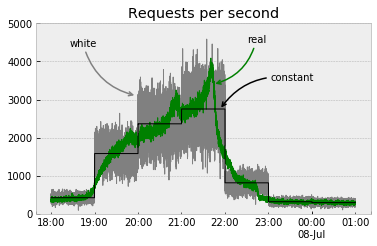

In [10]:
fig, ax = plt.subplots()
zoom = slice(start, end)

df_wc_traces['white'][zoom].plot(ax=ax, linewidth=1,
                                 color=COLOR_WHITE)
df_real_secs['requests'][zoom].plot(ax=ax, linewidth=1,
                                    color=COLOR_REAL)
df_wc_traces['constant'][zoom].plot(ax=ax, linewidth=1,  figsize=(6, 3.5),
                                    title='Requests per second',
                                    color=COLOR_CONSTANT,
                                    ylim=(0, 5000))
ax.annotate('constant', xy=(0.55, 0.549), xycoords='axes fraction',
            xytext=(0.7, 0.7), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_CONSTANT,
                lw=1.5,
                connectionstyle='arc3,rad=0.3',
                ),
            )
ax.annotate('real', xy=(0.53, 0.68), xycoords='axes fraction',
            xytext=(0.63, 0.9), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_REAL,
                lw=1.5,
                connectionstyle='arc3,rad=-0.3',
                ),
            )

ax.annotate('white', xy=(0.3, 0.62), xycoords='axes fraction',
            xytext=(0.1, 0.88), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_WHITE,
                lw=1.5,
                connectionstyle='arc3,rad=0.3',
                ),
            )

ax.xaxis.grid(False)
fig.savefig('figs/traces-white.png', bbox_inches='tight', dpi=300)

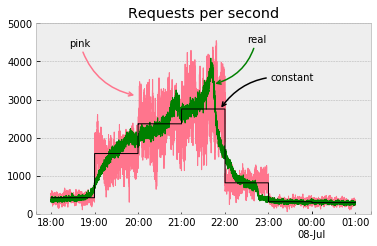

In [11]:
fig, ax = plt.subplots()
zoom = slice(start, end)

df_wc_traces['pink'][zoom].plot(ax=ax, linewidth=1,
                                color=COLOR_PINK,
                                )
df_real_secs['requests'][zoom].plot(ax=ax, linewidth=1,
                                    color=COLOR_REAL)
df_wc_traces['constant'][zoom].plot(ax=ax, linewidth=1,  figsize=(6, 3.5),
                                    title='Requests per second',
                                    color=COLOR_CONSTANT,
                                    ylim=(0, 5000))
ax.annotate('constant', xy=(0.55, 0.549), xycoords='axes fraction',
            xytext=(0.7, 0.7), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_CONSTANT,
                lw=1.5,
                connectionstyle='arc3,rad=0.3',
                ),
            )
ax.annotate('real', xy=(0.53, 0.68), xycoords='axes fraction',
            xytext=(0.63, 0.9), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_REAL,
                lw=1.5,
                connectionstyle='arc3,rad=-0.3',
                ),
            )

ax.annotate('pink', xy=(0.3, 0.62), xycoords='axes fraction',
            xytext=(0.1, 0.88), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_PINK,
                lw=1.5,
                connectionstyle='arc3,rad=0.3',
                ),
            )

ax.xaxis.grid(False)
fig.savefig('figs/traces-pink.png', bbox_inches='tight', dpi=300)

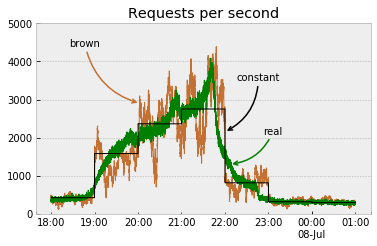

In [12]:
fig, ax = plt.subplots()
zoom = slice(start, end)

df_wc_traces['brown'][zoom].plot(ax=ax, linewidth=1,
                                color=COLOR_BROWN,
                                )
df_real_secs['requests'][zoom].plot(ax=ax, linewidth=1,
                                    color=COLOR_REAL)
df_wc_traces['constant'][zoom].plot(ax=ax, linewidth=1,  figsize=(6, 3.5),
                                    title='Requests per second',
                                    color=COLOR_CONSTANT,
                                    ylim=(0, 5000))
ax.annotate('constant', xy=(0.565, 0.43), xycoords='axes fraction',
            xytext=(0.6, 0.7), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_CONSTANT,
                lw=1.5,
                connectionstyle='arc3,rad=-0.3',
                ),
            )
ax.annotate('real', xy=(0.58, 0.26), xycoords='axes fraction',
            xytext=(0.68, 0.42), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_REAL,
                lw=1.5,
                connectionstyle='arc3,rad=-0.3',
                ),
            )

ax.annotate('brown', xy=(0.31, 0.58), xycoords='axes fraction',
            xytext=(0.1, 0.88), textcoords='axes fraction',
            arrowprops=dict(arrowstyle='->',
                color=COLOR_BROWN,
                lw=1.5,
                connectionstyle='arc3,rad=0.3',
                ),
            )

ax.xaxis.grid(False)
fig.savefig('figs/traces-brown.png', bbox_inches='tight', dpi=300)